# Poisson process likelihood

Test case for a poisson process with a simple synthetic dataset of 1 dimensional events. 

The goal is to train a NN to predict intensity function for a uniformly sampled set of X's between 0 and 1.

TODO: train a scalable GP to do the same!

Reference: https://homepages.inf.ed.ac.uk/imurray2/pub/09poisson/adams-murray-mackay-2009b.pdf


In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import torch
import math
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

from torch import nn
from torch.distributions.poisson import Poisson
import tqdm
from mpl_toolkits.mplot3d import Axes3D

torch.manual_seed(0)

Populating the interactive namespace from numpy and matplotlib


Create 2 source distributions to sample from and graph them. All sampled events are 1 dimensional tensors whose values are in [0,1]. These events are our training set.

In [2]:
inputs_x = np.linspace(0, 1, 500)
inputs_y = np.linspace(0, 2*math.pi, 500)
num_samples = 20
samples1 = [np.random.beta(20, 70) for x in range(num_samples)]
samples2 = [np.random.beta(70, 20) for x in range(num_samples)]
all_samples = torch.tensor(samples1 + samples2)
print(all_samples.shape)

torch.Size([40])


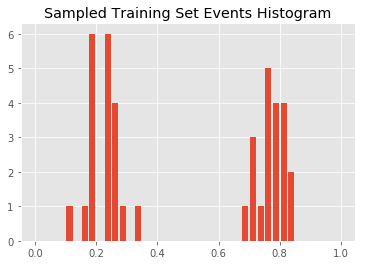

In [3]:
plt.title("Sampled Training Set Events Histogram")
p = plt.hist(all_samples, range=(0, 1), rwidth=0.8, bins=40)

In [4]:
all_samples

tensor([0.1840, 0.2378, 0.2522, 0.2391, 0.2271, 0.2343, 0.1826, 0.1772, 0.1222,
        0.2446, 0.1899, 0.2782, 0.2679, 0.1586, 0.2708, 0.1932, 0.2732, 0.3309,
        0.2443, 0.1838, 0.7121, 0.7480, 0.7880, 0.8232, 0.8232, 0.7568, 0.7200,
        0.7701, 0.7810, 0.8082, 0.7986, 0.7104, 0.6794, 0.8291, 0.7642, 0.8163,
        0.7666, 0.7903, 0.8396, 0.7694])

In [5]:
from gpytorch.likelihoods import PoissonProcessLikelihood
from gpytorch.models import AbstractVariationalGP
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.means import ZeroMean
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.distributions import MultivariateNormal

class PoissonProcessGPModel(AbstractVariationalGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(self, train_x, variational_distribution)
        super(PoissonProcessGPModel, self).__init__(variational_strategy)
        self.mean_module = ZeroMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = MultivariateNormal(mean_x, covar_x)
        return latent_pred


In [6]:
all_samples = all_samples.double()
x_grid = torch.linspace(0, 1, all_samples.size(-1)).double()
model = PoissonProcessGPModel(all_samples).double()

In [7]:
min_bounds = torch.tensor([0.]).double()
max_bounds = torch.tensor([1.]).double()
likelihood = PoissonProcessLikelihood(min_bounds, max_bounds).double()

In [8]:
model(all_samples)

MultivariateNormal(loc: torch.Size([40]))

In [9]:
model.variational_strategy.variational_distribution.variational_mean.data.copy_(torch.randn(x_grid.size(0)) * 0.01)

tensor([-1.1258e-02, -1.1524e-02, -2.5058e-03, -4.3388e-03,  8.4871e-03,
         6.9201e-03, -3.1601e-03, -2.1152e-02,  3.2227e-03, -1.2633e-02,
         3.4998e-03,  3.0813e-03,  1.1984e-03,  1.2377e-02,  1.1168e-02,
        -2.4728e-03, -1.3527e-02, -1.6959e-02,  5.6665e-03,  7.9351e-03,
         5.9884e-03, -1.5551e-02, -3.4136e-03,  1.8530e-02, -2.1586e-03,
        -7.4255e-03,  5.6272e-03,  2.5963e-03, -1.7396e-03, -6.7875e-03,
         9.3826e-03,  4.8887e-03,  1.2032e-02,  8.4535e-04, -1.2001e-02,
        -4.7857e-05, -5.1807e-03, -3.0670e-03, -1.5810e-02,  1.7066e-02],
       dtype=torch.float64)

In [10]:
model.variational_strategy.variational_distribution.chol_variational_covar.data = torch.eye(x_grid.size(0)) + 0.01 * torch.randn(x_grid.size(0), x_grid.size(0)).triu(1)

In [11]:
model.variational_strategy.variational_distribution.chol_variational_covar.data = model.variational_strategy.variational_distribution.chol_variational_covar.data.double()

In [12]:
model.variational_strategy.variational_distribution.chol_variational_covar

Parameter containing:
tensor([[ 1.0000e+00, -4.5033e-03, -5.7308e-03,  ...,  7.9150e-03,
         -2.0252e-04, -4.3717e-03],
        [ 0.0000e+00,  1.0000e+00,  9.6630e-03,  ...,  1.0833e-03,
         -7.5482e-03,  2.4432e-03],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  ..., -1.1964e-02,
          1.9703e-03, -1.1773e-02],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          1.0022e-02,  3.1684e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          1.0000e+00,  1.4079e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00]], dtype=torch.float64, requires_grad=True)

In [13]:
model.variational_strategy.variational_distribution.variational_mean

Parameter containing:
tensor([-1.1258e-02, -1.1524e-02, -2.5058e-03, -4.3388e-03,  8.4871e-03,
         6.9201e-03, -3.1601e-03, -2.1152e-02,  3.2227e-03, -1.2633e-02,
         3.4998e-03,  3.0813e-03,  1.1984e-03,  1.2377e-02,  1.1168e-02,
        -2.4728e-03, -1.3527e-02, -1.6959e-02,  5.6665e-03,  7.9351e-03,
         5.9884e-03, -1.5551e-02, -3.4136e-03,  1.8530e-02, -2.1586e-03,
        -7.4255e-03,  5.6272e-03,  2.5963e-03, -1.7396e-03, -6.7875e-03,
         9.3826e-03,  4.8887e-03,  1.2032e-02,  8.4535e-04, -1.2001e-02,
        -4.7857e-05, -5.1807e-03, -3.0670e-03, -1.5810e-02,  1.7066e-02],
       dtype=torch.float64, requires_grad=True)

In [14]:
likelihood._integrate_moments(model)

tensor(0.3628, dtype=torch.float64, grad_fn=<AddBackward0>)

In [15]:
all_samples = all_samples.double()
likelihood.variational_log_probability(model(all_samples), all_samples, model)

-50.73626780556623 0.3627639340191431


tensor(-51.1009, dtype=torch.float64, grad_fn=<AddBackward0>)

In [16]:
model.variational_strategy.variational_params_initialized

tensor(1)

In [29]:
from gpytorch.mlls.variational_elbo import VariationalELBO
import gpytorch

train_y = all_samples

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the amount of training data
mll = VariationalELBO(likelihood, model, train_y.numel())

training_iter = 500
for i in range(training_iter):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    with gpytorch.settings.max_preconditioner_size(10):
        output = model(all_samples)
        # Calc loss and backprop gradients
        loss = -mll.forward(output, all_samples, model=model)
        loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

105.084467023995 24.712238296934895
Iter 1/500 - Loss: -1.956
107.2156046396846 25.674349402835546
Iter 2/500 - Loss: -1.659
108.29876557427588 25.07304527905814
Iter 3/500 - Loss: -1.916
112.06892753567416 25.19461548944222
Iter 4/500 - Loss: -1.863
110.87729489672464 25.3267697456203
Iter 5/500 - Loss: -1.786
110.23385943077011 25.16944976128875
Iter 6/500 - Loss: -1.832
110.72417119392954 24.934072069359345
Iter 7/500 - Loss: -1.914
109.15296450043452 24.860402547778172
Iter 8/500 - Loss: -1.937
110.09381709350599 24.968868647246655
Iter 9/500 - Loss: -1.908
110.10758091871514 25.08735460967023
Iter 10/500 - Loss: -1.873
108.10496817538953 25.098888681828516
Iter 11/500 - Loss: -1.876
112.87309076695169 25.036625854977277
Iter 12/500 - Loss: -1.911
114.6940883549216 24.98458780613559
Iter 13/500 - Loss: -1.942
107.28799966438899 24.988440026678095
Iter 14/500 - Loss: -1.944
107.5412169743354 25.023465557129047
Iter 15/500 - Loss: -1.930
109.75730244019559 25.03041709501491
Iter 16/5

Iter 128/500 - Loss: -1.963
110.50786812581704 25.84379289835017
Iter 129/500 - Loss: -1.977
110.58732038055658 25.850880044183846
Iter 130/500 - Loss: -1.981
110.96890094192682 25.860489188704186
Iter 131/500 - Loss: -1.980
110.47670931626641 25.868494107631186
Iter 132/500 - Loss: -1.981
113.10044588494225 25.880354417743344
Iter 133/500 - Loss: -1.983
109.81020495825337 25.890045429908284
Iter 134/500 - Loss: -1.972
110.37108128455976 25.899169447561103
Iter 135/500 - Loss: -1.983
111.90002936080256 25.90897362710243
Iter 136/500 - Loss: -1.981
115.34128099037422 25.918522463793153
Iter 137/500 - Loss: -1.974
108.73522438720073 25.929662592727162
Iter 138/500 - Loss: -1.973
109.6228917881299 25.939754465447404
Iter 139/500 - Loss: -1.974
111.72851220255117 25.951914645241594
Iter 140/500 - Loss: -1.990
110.97962433589838 25.96527431110665
Iter 141/500 - Loss: -1.975
112.21962676204382 25.979125127613795
Iter 142/500 - Loss: -1.969
112.37015733482349 25.992305131361938
Iter 143/500 -

Iter 261/500 - Loss: -1.999
111.14614000179985 27.29844208073933
Iter 262/500 - Loss: -1.999
114.80068985177101 27.308837043028408
Iter 263/500 - Loss: -2.007
110.33650138115597 27.319702625128713
Iter 264/500 - Loss: -2.004
113.33768259458498 27.327321202323123
Iter 265/500 - Loss: -2.012
113.26879474494325 27.338741432486284
Iter 266/500 - Loss: -2.002
114.94389441204451 27.350170525708595
Iter 267/500 - Loss: -2.004
114.61933561577308 27.363169678179617
Iter 268/500 - Loss: -2.007
112.86786836023761 27.37402495519457
Iter 269/500 - Loss: -2.003
113.52974461730872 27.38844801357275
Iter 270/500 - Loss: -1.997
111.48476760902786 27.399889574494754
Iter 271/500 - Loss: -2.008
110.37978652064942 27.413428822896567
Iter 272/500 - Loss: -2.006
109.3876814098552 27.428766636578597
Iter 273/500 - Loss: -2.009
116.31753619617001 27.446751555950502
Iter 274/500 - Loss: -2.011
111.70162138609763 27.464165799077165
Iter 275/500 - Loss: -2.009
113.09206720091174 27.48233052222047
Iter 276/500 - 

Iter 395/500 - Loss: -2.028
118.47089825309739 29.098231984349212
Iter 396/500 - Loss: -2.032
115.35449973111453 29.119047609067902
Iter 397/500 - Loss: -2.026
119.84208089354294 29.13514887617385
Iter 398/500 - Loss: -2.034
113.70941532473569 29.146177348396172
Iter 399/500 - Loss: -2.032
116.86250323882989 29.153794318782953
Iter 400/500 - Loss: -2.009
118.79184667487694 29.15741098046314
Iter 401/500 - Loss: -2.029
115.70546472339157 29.15953125029105
Iter 402/500 - Loss: -2.033
114.97831592522924 29.163429482070377
Iter 403/500 - Loss: -2.037
119.8195974084152 29.16963389534991
Iter 404/500 - Loss: -2.031
116.28801744064026 29.1813803658904
Iter 405/500 - Loss: -2.033
116.90986340695821 29.19117855662094
Iter 406/500 - Loss: -2.031
116.56322128721081 29.20472994423859
Iter 407/500 - Loss: -2.032
116.7071168120732 29.21683093589671
Iter 408/500 - Loss: -2.027
117.46804087907167 29.229649600564642
Iter 409/500 - Loss: -2.023
117.53190972010864 29.236683671403775
Iter 410/500 - Loss: 

In [30]:
model.eval()
x_grid_dense = torch.linspace(0, 1, 100).double()
preds = model(x_grid_dense)

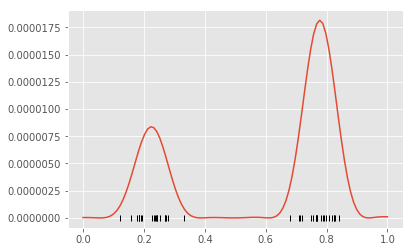

In [32]:
plt.plot(x_grid_dense.numpy(), preds.mean.pow(2).detach().numpy())
plt.plot(all_samples.numpy(), np.zeros(40), 'k|')